In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
from WeakLearners import WongNeuralNetCIFAR10
import matplotlib.pyplot as plt


In [2]:
from Boosting import runBoosting

In [3]:
import utils

In [1]:
cuda = torch.device('cuda:0')

NameError: name 'torch' is not defined

## Vanilla PreactResNet

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=300, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
cifar10_vanilla = WongNeuralNetCIFAR10()
cifar10_vanilla.fit(train_loader, test_loader, alpha = 0, epochs = 15, adv=False, epsilon=0)
print("done")

adv: False
maxIt: None
Epoch 0
it 1 val accuracy: 0.0833
it 101 val accuracy: 0.4400
it 201 val accuracy: 0.4867
it 301 val accuracy: 0.5533
it 401 val accuracy: 0.6000
Epoch 1
it 1 val accuracy: 0.6200
it 101 val accuracy: 0.6600
it 201 val accuracy: 0.7100
it 301 val accuracy: 0.7200
it 401 val accuracy: 0.7467
Epoch 2
it 1 val accuracy: 0.7567
it 101 val accuracy: 0.7100
it 201 val accuracy: 0.7300
it 301 val accuracy: 0.7567
it 401 val accuracy: 0.7600
Epoch 3
it 1 val accuracy: 0.7667
it 101 val accuracy: 0.7833
it 201 val accuracy: 0.8100
it 301 val accuracy: 0.7633
it 401 val accuracy: 0.7600
Epoch 4
it 1 val accuracy: 0.7800
it 101 val accuracy: 0.7767
it 201 val accuracy: 0.8133
it 301 val accuracy: 0.8167
it 401 val accuracy: 0.8200
Epoch 5
it 1 val accuracy: 0.8300
it 101 val accuracy: 0.8067
it 201 val accuracy: 0.8200
it 301 val accuracy: 0.8000
it 401 val accuracy: 0.8067
Epoch 6
it 1 val accuracy: 0.8233
it 101 val accuracy: 0.8067
it 201 val accuracy: 0.7933
it 301 val 

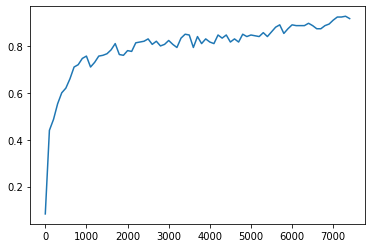

In [13]:
# cifar10_vanilla.plot_val_accuracies()
plt.plot(np.arange(0, len(cifar10_vanilla.val_accuracies*100), 100), cifar10_vanilla.val_accuracies)

In [ ]:
print(len(cifar10_vanilla.iters), len(cifar10_vanilla.val_accuracies))

## Experiments for CIFAR10 boosting

In [5]:
maxSamples_vals = [30000]
# maxIt_vals = [10, 50, 100, 500]
# maxIt_vals = [200, 500]
# maxIt_vals = [10]
# default maxIt for weak learner is infinity (i.e. runs each epoch on the entire batch)

In [6]:
num_wl = 100 # maybe around 100? #later: maybe change this to an array?

In [7]:
all_val_accuracies_ensemble = []
all_train_accuracies_ensemble = []
all_train_accuracies = []
all_wl = []
all_wl_weights = []

In [8]:
# from pytorch_memlab import LineProfiler
# from Boosting import SchapireWongMulticlassBoostingMemoryLess
# with LineProfiler(runMemlessBoosting, SchapireWongMulticlassBoostingMemoryLess) as prof:
for maxSamples in maxSamples_vals:
    wl, wl_weights, train_accuracies, val_accuracies_ensemble, train_accuracies_ensemble = runBoosting(num_wl, maxSamples)
    all_val_accuracies.append(val_accuracies)
    all_wl.append(wl)
    all_wl_weights.append(wl_weights)
    all_train_accuracies_ensemble.append(train_accuracies_ensemble)
# prof.display()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------------------------------------------
Training weak learner 0
adv: False
Epoch 0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/cifar.py:118: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img, target = self.data[index], self.targets[index]


it 99 val accuracy: 0.3100
it 199 val accuracy: 0.4300


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Training accuracy of weak learner:  0.46132
Alpha:  0.4253961840207111
----------------------------------------------------------------------------------------------------
Training weak learner 1
adv: False
Epoch 0
it 99 val accuracy: 0.3000
it 199 val accuracy: 0.4250
Training accuracy of weak learner:  0.4337
Alpha:  0.31354413940408005
Files already downloaded and verified
Files already downloaded and verified
After newest WL validation score is:  0.46874999999999994
After newest WL training score is:  0.45124999999999993
----------------------------------------------------------------------------------------------------
Training weak learner 2
adv: False
Epoch 0
it 99 val accuracy: 0.2750
it 199 val accuracy: 0.4150
Training accuracy of weak learner:  0.41134
Alpha:  0.25336546119683684
----------------------------------------------------------------------------------------------------
Training weak learner 3
adv: False
Epoch 0
it 99 val accuracy: 0.3200
it 199 val accuracy: 0.4750

NameError: name 'train_accuracies_ensemble' is not defined

In [3]:
def generate_plots():
    for i in range(len(maxSamples)):
        maxSamples = maxSamples_vals[i]
        # plot for wl train accuracies
        plt.subplots()
        wl_train_accuracies = all_train_accuracies[i]
        plt_path = f'results/plots/wl_train_accuracies_maxSamples_{maxSamples}'
        plt.xlabel("Num weak learners")
        plt.ylabel("Weak learner train accuracy")
        plt.savefig(plt_path)
        
        # plot for ensemble train + val accuracies
        plt.subplots()
        train_accuracies_ensemble = all_train_accuracies_ensemble[i]
        val_accuracies_ensemble = all_val_accuracies_ensemble[i]
        wl_range = [10 * i + 1 for i in range(len(train_accuracies_ensemble))]
        plt.plot(wl_range, train_accuracies_ensemble)
        plt.plot(wl_range, val_accuracies_ensemble)
        plt.xlabel("Num weak learners")
        plt.ylabel("Accuracy")
        plt.legend(["Ensemble train accuracy", "Ensemble val accuracy"])
        plt_path = f'results/plots/wl_ensemble_accuracies_maxSamples_{maxSamples}'
        plt.savefig(plt_path)

SyntaxError: unexpected EOF while parsing (<ipython-input-3-62f32e82603e>, line 3)

In [1]:
# TODO: plot the accuracies for each usage of maxIt
legend_labels = []
for i in range(len(maxIt_vals)):
    maxIt = maxIt_vals[i]
    val_accuracies = all_val_accuracies[i]
    num_wl = len(all_wl[i])
    plt.plot(np.arange(maxIt, num_wl * maxIt + 1, maxIt), val_accuracies)
    plt.xlabel("Num weak learners")
    plt.ylabel("Accuracy")
    legend_labels.append(f"MaxIt: {maxIt}")
plt.legend(legend_labels)
plt.show()
    

NameError: name 'maxIt_vals' is not defined

In [ ]:
# Ensemble score (training, val)
# weak learner score (training)
# different plot for each maxSamples

In [ ]:
import csv

for i in range(len(maxSamples_vals)):
    maxSamples = maxSamples_vals[i]
    wl = all_wl[i]
    wl_weights = all_wl_weights[i]
    val_accuracies_ensemble = all_val_accuracies_ensemble[i]
    train_accuracies_ensemble = all_train_accuracies_ensemble[i]
    train_accuracies_wl = all_train_accuracies[i]
#     val_accuracies = all_val_accuracies[i]
    wl_file = f"./results/wl_maxSamples_{maxSamples}.csv"
    wl_weights_file = f"./results/wl_weights_maxSamples_{maxSamples}.csv"
    wl_train_acc_file = f"./results/wl_train_accuracy_{maxSamples}.csv"
    ensemble_train_acc_file = f"./results/ensemble_train_accuracy_{maxSamples}.csv"
    ensemble_val_acc_file = f"./results/ensemble_val_accuracy_{maxSamples}.csv"
    with open(wl_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(wl)
    with open(wl_weights_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(wl_weights)
    with open(wl_train_acc_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(train_accuracies_wl)
    with open(ensemble_train_acc_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(train_accuracies_ensemble)
    with open(ensemble_val_acc_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(val_accuracies_ensemble)
    

In [ ]:
# Potential idea: maybe compare wall-clock time b/w CIFAR10 boosting and regular nn training to reach a certain accuracy threshold?

## Compare with other benchmarks? (i.e. other pretrained ensembles?)